# ``pygraph`` 简介


在 JAX 中，各种强大的函数转换适用于 pytree数据结构（即字典、列表、元组等树状结构）。基于pytree，JAX 可以有效地执行微分、向量化和并行化操作。然而，许多实际的应用场景，特别是复杂的物理结构和神经网络模型，其本质上更适合用图 (graph) 而非简单的树结构来表示。因此，为了扩展 JAX 对于图结构的支持，``brainstate`` 库引入了 ``pygraph`` 模块，为 JAX 提供了强大的图形结构支持，使得用户可以在复杂的模型状态管理和变换操作中使用图结构。

## 什么是 ``pygraph``？

``pygraph`` 是 ``brainstate`` 中专门设计用于支持 JAX 函数转换的数据结构。与常见的树结构相比，图结构能够表达更多样的节点关系和依赖性，适用于更加复杂的模型结构。特别是当模型状态需要依赖于多个节点的交互作用时，图结构在表达上更为灵活。``pygraph`` 模块以 ``brainstate.graph.Node`` 作为图的基本节点，通过定义节点之间的关系（边）来构建一个图形结构。每个节点可以包含任意的 pytree 数组数据或 ``pygraph`` 子结构，从而使图的构建更加灵活和模块化。

我们可以将 ``brainstate.graph.Node`` 视作一个类容器，该类的属性属于其叶子。容器之间可以相互引用，形成复杂的图结构。

In [1]:
import brainstate as bst
import jax
import jax.numpy as jnp

In [2]:
class A(bst.graph.Node):
    def __init__(self):
        self.w = bst.random.rand(2, 3)
        self.b = bst.ShortTermState(bst.random.rand(3))

在上面的代码中，我们定义了一个类 ``A``，该类继承自 ``brainstate.graph.Node``。在类的初始化函数中，我们定义了两个属性 ``w`` 和 ``b``，分别为一个随机生成的 2x3 矩阵和一个随机生成的长度为 3 的数组。这两个数据结构都是 JAX 的 pytree 结。但是，``brainstate.graph.Node`` 运行我们创建循环引用。比如：

In [3]:
a = A()
a.self = a

在这里，我们将 ``a`` 的 ``self`` 属性设置为 ``a``，这样就形成了一个循环引用。这种引用方式在树结构中是不允许的，但在图结构中是允许的。这种引用方式可以用于表示复杂的模型结构，比如循环神经网络中的循环连接。

In [4]:
# 查看图结构

bst.graph.graphdef(a)

NodeDef(
  type=A,
  index=0,
  attributes=('b', 'self', 'w'),
  subgraphs={
    'self': NodeRef(
      type=A,
      index=0
    )
  },
  static_fields={
    'w': Array([[0.96316934, 0.75793946, 0.15561926],
           [0.5031538 , 0.4152527 , 0.3976587 ]], dtype=float32)
  },
  leaves={
    'b': NodeRef(
      type=ShortTermState,
      index=1
    )
  },
  metadata=(<class '__main__.A'>,),
  index_mapping=None
)

## ``brainstate.graph.Node`` 概述

``brainstate.graph.Node`` 是 ``pygraph`` 中的核心类，它定义了每个节点的结构和行为。每个节点的**属性**即为其叶子节点，可以是任意的 JAX 数组或其他可转换的数据类型。每个节点的**方法**为该节点针对其数据的操作和行为，可以通过节点的方法来实现对节点所包含数据的操作、更新和变换。

在 ``brainstate`` 中，任意的神经网络模块都是 ``brainstate.graph.Node`` 的子类。比如，我们可以定义一个简单的线性层模块：

In [5]:
class MLP(bst.graph.Node):
    def __init__(self):
        self.l1 = bst.nn.Linear(2, 3)
        self.l2 = bst.nn.Linear(3, 4)
        self.l3 = bst.nn.Linear(4, 5)
        self.st = bst.ShortTermState(bst.random.rand(5))

可以通过以下属性和方法创建和操作节点：

- **数据存储**：每个``brainstate.graph.Node``节点的*属性*可以存储任意 JAX 数组或其他可转换的数据类型。
- **节点连接**：每个``brainstate.graph.Node``节点的*属性*可以连接到别的``brainstate.graph.Node``节点，从而建立复杂的依赖图。如上面的``MLP``类中的三个线性层模块。
- **属性及其路径**：每个``brainstate.graph.Node``节点在检索和转换的时候包含其独特的路径，便于在复杂结构中进行识别和检索。其路径即为其在图中各种层次嵌套结构中的位置。

比如，我们可以通过以下代码查看 ``MLP`` 图中的叶子数据点：

In [6]:
mlp = MLP()

for path, leaf in bst.graph.iter_leaf(mlp):
    print(path, leaf.__class__.__name__ if isinstance(leaf, bst.State) else leaf)

('l1', '_in_size', 0) 2
('l1', '_out_size', 0) 3
('l1', 'weight') ParamState
('l2', '_in_size', 0) 3
('l2', '_out_size', 0) 4
('l2', 'weight') ParamState
('l3', '_in_size', 0) 4
('l3', '_out_size', 0) 5
('l3', 'weight') ParamState
('st',) ShortTermState


我们也可以通过如下代码查看 ``MLP`` 图中的所有节点：

In [7]:
for path, node in bst.graph.iter_node(mlp):
    print(path, node.__class__.__name__)

('l1',) Linear
('l2',) Linear
('l3',) Linear
() MLP


## ``pygraph``常用函数

``brainstate`` 提供了许多用于操作 ``pygraph`` 的实用程序。这些实用程序可以在 [``brainstate.graph`` 模块](../apis/graph.rst) 中找到。

大体来说，``pygraph``常用的函数主要分为以下几类：

- **图结构操作**：用于构建和检索图结构的函数，如 
    - ``brainstate.graph.graphdef``用于查看图结构、
    - ``brainstate.graph.iter_node``用于遍历图结构中的所有子节点
    - ``brainstate.graph.iter_leaf``用于遍历图结构中的所有数据
    - ``brainstate.graph.nodes``用于查看图结构中的所有节点
    - ``brainstate.graph.states``用于查看图结构中的所有``State``实例
- **图结构变换**：用于对图结构进行变换和操作的函数，如
    - ``brainstate.graph.treefy_states``用于将图结构中的所有``State``实例转换为pytree
    - ``brainstate.graph.clone``用于复制图结构
    - ``brainstate.graph.treefy_split``用于将图结构拆分为图结构``graphdef``和pytree化的``State``
    - ``brainstate.graph.treefy_merge``用于将图结构``graphdef``和pytree化的``State``合并为图结构
- **图结构修改**：用于对图结构进行修改和更新的函数，如
    - ``brainstate.graph.pop_states``用于删除图结构中的满足某种条件的``State``实例，见下文的[``filter``协议](#filter)部分
    - ``brainstate.graph.update_states``用于更新图结构中的满足某种条件的``State``实例
- **图结构转换**：用于pygraph和pytree数据结构相互转换的函数，如
    - ``brainstate.graph.graph_to_tree``用于将图结构转换为pytree
    - ``brainstate.graph.tree_to_graph``用于将pytree转换为图结构

在介绍了``pygraph``的基本概念和常用函数之后，我们将通过一个简单的例子来展示如何使用``pygraph``模块构建和操作图结构。

In [8]:
# 分割图结构为 graphdef 和 树化的states

graphdef, tree_states = bst.graph.treefy_split(mlp)

In [9]:
graphdef

NodeDef(
  type=MLP,
  index=0,
  attributes=('l1', 'l2', 'l3', 'st'),
  subgraphs={
    'l1': NodeDef(
      type=Linear,
      index=1,
      attributes=('_in_size', '_name', '_out_size', 'w_mask', 'weight'),
      subgraphs={
        '_in_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 2
          },
          leaves={},
          metadata=PyTreeDef((*,)),
          index_mapping=None
        ),
        '_name': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=None
        ),
        '_out_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(0,),
          subgraphs={},
          static_fields={
            0: 3
          },
          leaves={},
          metadata=PyTreeDef((*,)),
   

In [10]:
tree_states

NestedDict({
  'l1': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[-0.9621243 ,  0.6099288 ,  1.7925913 ],
             [ 1.0093921 , -0.16140677, -1.1245121 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)},
      tag=None
    )
  },
  'l2': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[ 1.0511595 ,  0.95263714, -0.43481904, -0.6413494 ],
             [-0.46692452, -0.7826885 ,  0.2867147 , -0.04088842],
             [-0.55682147, -0.50789666,  0.9836989 , -0.25435624]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)},
      tag=None
    )
  },
  'l3': {
    'weight': TreefyState(
      type=ParamState,
      value={'weight': Array([[ 1.4066998 , -0.2079093 ,  0.2848766 , -1.0898389 , -0.11604771],
             [ 0.6823486 , -0.28052783, -0.15005152,  0.04554871, -0.1203554 ],
             [ 0.00459637, -0.4027815 , -0.06394981, -0.02355323, -1.4451013 ],
             [-0.70159

In [11]:
# 合并图结构和树化的states

mlp2 = bst.graph.treefy_merge(graphdef, tree_states)

mlp2

MLP(
  l1=Linear(
    in_size=(2,),
    out_size=(3,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[-0.9621243 ,  0.6099288 ,  1.7925913 ],
             [ 1.0093921 , -0.16140677, -1.1245121 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
    )
  ),
  l2=Linear(
    in_size=(3,),
    out_size=(4,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[ 1.0511595 ,  0.95263714, -0.43481904, -0.6413494 ],
             [-0.46692452, -0.7826885 ,  0.2867147 , -0.04088842],
             [-0.55682147, -0.50789666,  0.9836989 , -0.25435624]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
    )
  ),
  l3=Linear(
    in_size=(4,),
    out_size=(5,),
    w_mask=None,
    weight=ParamState(
      value={'weight': Array([[ 1.4066998 , -0.2079093 ,  0.2848766 , -1.0898389 , -0.11604771],
             [ 0.6823486 , -0.28052783, -0.15005152,  0.04554871, -0.1203554 ],
             [ 0.00459637, -0.4027815 , -0.06394981,

In [12]:
# 查看图结构中的所有states

states = bst.graph.states(mlp2)

states

FlattedDict({
  ('l1', 'weight'): ParamState(
    value={'weight': Array([[-0.9621243 ,  0.6099288 ,  1.7925913 ],
           [ 1.0093921 , -0.16140677, -1.1245121 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
  ),
  ('l2', 'weight'): ParamState(
    value={'weight': Array([[ 1.0511595 ,  0.95263714, -0.43481904, -0.6413494 ],
           [-0.46692452, -0.7826885 ,  0.2867147 , -0.04088842],
           [-0.55682147, -0.50789666,  0.9836989 , -0.25435624]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
  ),
  ('l3', 'weight'): ParamState(
    value={'weight': Array([[ 1.4066998 , -0.2079093 ,  0.2848766 , -1.0898389 , -0.11604771],
           [ 0.6823486 , -0.28052783, -0.15005152,  0.04554871, -0.1203554 ],
           [ 0.00459637, -0.4027815 , -0.06394981, -0.02355323, -1.4451013 ],
           [-0.7015993 ,  0.746923  , -0.26789007,  0.26303273,  0.6402506 ]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}
  ),
  ('st',

值得注意的是，对于大部分检索``State``实例的图操作函数，都支持传入一系列``filter``函数，用于筛选出满足某种条件的``State``实例。比如，如果只需要筛选出所有的``ShortTermState``实例，可以通过以下代码实现：

In [13]:
short_term_states = bst.graph.states(mlp2, bst.ShortTermState)

short_term_states

FlattedDict({
  ('st',): ShortTermState(
    value=Array([0.4263394 , 0.21557069, 0.18960547, 0.14944589, 0.37569678],      dtype=float32)
  )
})

## ``filter`` 过滤器语法


一般来说，``filter``具有如下函数形式：

```python
def predicate(path: tuple[Key, ...], value: Any) -> bool:
    ...
```

其中 `Key` 是可hash和可比较的数据类型（往往是字符串），`path` 是表示`value`所对应的路径嵌套结构的 `Key` 元组，`value` 是路径上的值。如果值应包含在该``filter``中，函数返回 `True`，否则返回 `False`。

比如，我们可以定义一个 ``filter`` 函数，用于筛选出所有的 ``ParamState`` 实例：

In [14]:
def is_param(path, value) -> bool:
  return isinstance(value, bst.ParamState)

print(f'{is_param((), bst.ParamState(0.)) = }')

is_param((), bst.ParamState(0.)) = True


但是，为了简化 ``filter`` 函数的创建， ``brainstate`` 提供了一个小型的 DSL。该类型允许用户传递类型、布尔值、省略号、元组/列表等，并在内部将它们转换为相应的谓词、元组/列表等。

| 字面量 | 可调用对象 | 描述 |
|--------|----------------------|-------------|
| `...` 或 `True` | `Everything()` | 匹配所有值 |
| `None` 或 `False` | `Nothing()` | 不匹配任何值 |
| `type` | `OfType(type)` | 匹配类型为 `type` 的实例,或具有类型为 `type` 的 `type` 属性的值 |
| | `PathContains(key)` | 匹配关联的 `path` 中包含指定 `key` 的值 |
| `'{filter}'` <span style="color:gray">str</span> | `WithTag('{filter}')` | 匹配具有等于 `'{filter}'` 的字符串 `tag` 属性的值。被 `RngKey` 和 `RngCount` 使用。|
| `(*filters)` <span style="color:gray">tuple</span> 或 `[*filters]` <span style="color:gray">list</span> | `Any(*filters)` | 匹配满足任一内部 `filters` 的值 |
| | `All(*filters)` | 匹配满足所有内部 `filters` 的值 |
| | `Not(filter)` | 匹配不满足内部 `filter` 的值 |

比如，我们可以使用 ``filter`` DSL 来定义一个筛选出所有的 ``ParamState`` 实例和剩下的其他实例的 ``State``：

In [15]:
params, others = bst.graph.states(mlp, bst.ParamState, bst.ShortTermState)

params

FlattedDict({
  ('l1', 'weight'): ParamState(
    value={'weight': Array([[-0.9621243 ,  0.6099288 ,  1.7925913 ],
           [ 1.0093921 , -0.16140677, -1.1245121 ]], dtype=float32), 'bias': Array([0., 0., 0.], dtype=float32)}
  ),
  ('l2', 'weight'): ParamState(
    value={'weight': Array([[ 1.0511595 ,  0.95263714, -0.43481904, -0.6413494 ],
           [-0.46692452, -0.7826885 ,  0.2867147 , -0.04088842],
           [-0.55682147, -0.50789666,  0.9836989 , -0.25435624]],      dtype=float32), 'bias': Array([0., 0., 0., 0.], dtype=float32)}
  ),
  ('l3', 'weight'): ParamState(
    value={'weight': Array([[ 1.4066998 , -0.2079093 ,  0.2848766 , -1.0898389 , -0.11604771],
           [ 0.6823486 , -0.28052783, -0.15005152,  0.04554871, -0.1203554 ],
           [ 0.00459637, -0.4027815 , -0.06394981, -0.02355323, -1.4451013 ],
           [-0.7015993 ,  0.746923  , -0.26789007,  0.26303273,  0.6402506 ]],      dtype=float32), 'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}
  )
})

In [16]:
others

FlattedDict({
  ('st',): ShortTermState(
    value=Array([0.4263394 , 0.21557069, 0.18960547, 0.14944589, 0.37569678],      dtype=float32)
  )
})

## ``pygraph`` 与 ``pytree`` 的转换


``brainstate`` 提供了一系列用于 ``pygraph`` 和 ``pytree`` 之间相互转换的函数。这些函数可以在 [``brainstate.graph`` 模块](https://brainstate.readthedocs.io/en/latest/apis/graph.html) 中找到。特别的，我们在这里介绍两个常用的函数：

- ``brainstate.graph.treefy_split``：将图结构拆分为图结构和树化的``State``实例。这个函数可以用于将图结构中的所有``State``实例转换为pytree，并保留图结构中的其他节点结构信息。
- ``brainstate.graph.treefy_merge``：将图结构和树化的``State``实例重新合并为图结构。这个函数可以用于将pytree转换为图结构，并保留pytree中的其他节点结构信息。

这两个函数可以帮助用户在图结构和pytree之间进行灵活的转换，从而可以更方便地在复杂的模型结构中使用JAX的函数转换功能。

我们可以通过以下代码来演示这两个函数的使用：

In [17]:
class Linear(bst.nn.Module):
  def __init__(self, din: int, dout: int):
    super().__init__()
    self.w = bst.ParamState(bst.random.rand(din, dout))
    self.b = bst.ParamState(jnp.zeros((dout,)))

  def __call__(self, x):
    return x @ self.w.value + self.b.value


class Count(bst.State):
  pass


class MLP(bst.graph.Node):
  def __init__(self, din, dhidden, dout):
    self.count = Count(jnp.array(0))
    self.linear1 = Linear(din, dhidden)
    self.linear2 = Linear(dhidden, dout)

  def __call__(self, x):
    self.count.value += 1
    x = self.linear1(x)
    x = jax.nn.relu(x)
    x = self.linear2(x)
    return x

在上面的代码中，我们定义了一个简单的多层感知机模型 ``MLP``，其中包含两个线性层模块 ``Linear`` 和一个计数器 ``Count``。我们可以通过以下代码来查看这个模型的图结构：

In [18]:
model = MLP(1, 32, 1)

graphdef, params_, counts_ = bst.graph.treefy_split(MLP(din=1, dhidden=32, dout=1), bst.ParamState, Count)

params_

NestedDict({
  'linear1': {
    'b': TreefyState(
      type=ParamState,
      value=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
      tag=None
    ),
    'w': TreefyState(
      type=ParamState,
      value=Array([[0.62414145, 0.07261062, 0.8241935 , 0.04092729, 0.05797398,
              0.8666178 , 0.01890802, 0.31071007, 0.50239027, 0.8444326 ,
              0.31651413, 0.10141706, 0.9321823 , 0.07134902, 0.42645705,
              0.20488751, 0.60242355, 0.15487003, 0.13071549, 0.26182067,
              0.24925017, 0.90827644, 0.2778635 , 0.8973496 , 0.90867436,
              0.5319245 , 0.94377697, 0.80926585, 0.0513705 , 0.82726157,
              0.60745597, 0.02374911]], dtype=float32),
      tag=None
    )
  },
  'linear2': {
    'b': TreefyState(
      type=ParamState,
      value=Array([0.], dtype=float32),
      tag=None
    ),
    'w': TreefyState(
  

In [19]:
counts_

NestedDict({
  'count': TreefyState(
    type=Count,
    value=Array(0, dtype=int32, weak_type=True),
    tag=None
  )
})

## ``pygraph`` 与 JAX 函数转换

将``pygraph``转换为``pytree``后，我们可以使用JAX的函数转换功能对其进行操作。比如，我们可以使用JAX的``jit``函数对``MLP``模型进行编译，使用``grad``函数对其进行自动微分，使用``vmap``函数对其进行批量操作等。这些函数可以帮助用户更方便地对复杂的模型结构进行高效的计算操作。

我们首先定义一个简单的数据集：

In [20]:
X = jnp.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + bst.random.normal(0, 0.1, size=X.shape)


def dataset(batch_size):
  while True:
    idx = bst.random.choice(len(X), size=batch_size)
    yield X[idx], Y[idx]

接下来，我们使用``jax.jit``函数对``MLP``模型进行编译，并使用``jax.grad``函数对其进行自动微分：

In [21]:
@jax.jit
def train_step(params, counts, batch):
  x, y = batch

  def loss_fn(params):
    model = bst.graph.treefy_merge(graphdef, params, counts)
    y_pred = model(x)
    new_counts = bst.graph.treefy_states(model, Count)
    loss = jnp.mean((y - y_pred) ** 2)
    return loss, new_counts

  grad, counts = jax.grad(loss_fn, has_aux=True)(params)
  #                          |-------- sgd ---------|
  params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grad)

  return params, counts

我们再定义一个测试函数，用于计算模型的损失：

In [22]:
@jax.jit
def test_step(params, counts, batch):
  x, y = batch
  model = bst.graph.treefy_merge(graphdef, params, counts)
  y_pred = model(x)
  loss = jnp.mean((y - y_pred) ** 2)
  return {'loss': loss}

接下来，让我们开始训练模型：

In [23]:
total_steps = 10_000
for step, batch in enumerate(dataset(32)):
  params_, counts_ = train_step(params_, counts_, batch)

  if step % 1000 == 0:
    logs = test_step(params_, counts_, (X, Y))
    print(f"step: {step}, loss: {logs['loss']}")

  if step >= total_steps - 1:
    break

step: 0, loss: 1.5664312839508057
step: 1000, loss: 0.00912302453070879
step: 2000, loss: 0.00900690071284771
step: 3000, loss: 0.009030426852405071
step: 4000, loss: 0.008973325602710247
step: 5000, loss: 0.008971154689788818
step: 6000, loss: 0.008998032659292221
step: 7000, loss: 0.009022381156682968
step: 8000, loss: 0.008946777321398258
step: 9000, loss: 0.008950803428888321


最后，我们还原出模型，并查看模型的调用次数：

In [24]:
model = bst.graph.treefy_merge(graphdef, params_, counts_)
print('times called:', model.count.value)

times called: 10000


最后，我们可以使用训练好的模型对数据进行预测，并查看预测结果：

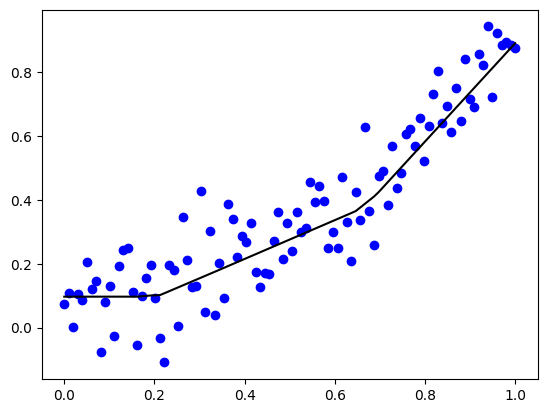

In [25]:
y_pred = model(X)

import matplotlib.pyplot as plt
plt.scatter(X, Y, color='blue')
plt.plot(X, y_pred, color='black')
plt.show()

## 原生支持 ``pygraph`` 的函数转换

``brainstate``也提供一些原生支持``pygraph``的函数转换，比如``brainstate.graph.grad``、``brainstate.graph.vmap``等[功能增强的函数转换](./program_augmentation.ipynb)。这些函数可以直接将``pygraph``实例输入到待转换的函数中，而无需用户显示地将其转换为``pytree``。

在下面的例子，我们定义了一个简单的神经网络模型，其中包含一个线性层模块和一个激活函数模块。但是，我们使用``vmap``函数对这一模型进行批量初始化，用于创建多层的神经网络模型：

In [30]:
class Block(bst.nn.Module):
  def __init__(self, dim: int):
    super().__init__()
    self.linear = bst.nn.Linear(dim, dim)
    self.bn = bst.nn.BatchNorm0d([dim])
    self.dropout = bst.nn.Dropout(0.5)

  def __call__(self, x: jax.Array):
    return jax.nn.gelu(self.dropout(self.bn(self.linear(x))))

In [31]:
dim = 2
n_layers = 5

@bst.augment.vmap_with_default_rng
def create_block(key):
  bst.random.set_key(key)
  return Block(dim)

layers = create_block(bst.random.split_key(n_layers))

layers

Block(
  bn=BatchNorm0d(
    in_size=(2,),
    out_size=(2,),
    affine=True,
    axis_index_groups=None,
    axis_name=None,
    bias_initializer=Constant(
      value=0.0
    ),
    dtype=<class 'numpy.float32'>,
    epsilon=Array(1.e-05, dtype=float32),
    feature_axis=(0,),
    momentum=Array(0.99, dtype=float32),
    running_mean=LongTermState(
      value=Array([[0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.]], dtype=float32)
    ),
    running_var=LongTermState(
      value=Array([[1., 1.],
             [1., 1.],
             [1., 1.],
             [1., 1.],
             [1., 1.]], dtype=float32)
    ),
    scale_initializer=Constant(
      value=1.0
    ),
    track_running_stats=True,
    weight=ParamState(
      value={'bias': Array([[0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.],
             [0., 0.]], dtype=float32), 'scale': Array([[1., 1.],
             [1., 1.],
             [1., 1.],
